In [32]:
import os   
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from Training_Prediction.FOMM.Source_Model.logger import Logger, Visualizer
import numpy as np
import imageio
from Training_Prediction.FOMM.Source_Model.sync_batchnorm import DataParallelWithCallback
from Training_Prediction.FOMM.Source_Model.modules.RNN_prediction_module import PredictionModule
from Training_Prediction.FOMM.Source_Model.augmentation import SelectRandomFrames, SelectFirstFrames_two, VideoToTensor
from tqdm import trange
from torch.utils.data import DataLoader, Dataset
from Training_Prediction.FOMM.Source_Model.frames_dataset import FramesDataset
import tensorflow.compat.v1 as tf
from Training_Prediction.PREDICTOR.Source_Model.VRNN import build_vrnn, get_config
import pickle
from Training_Prediction.PREDICTOR.Source_Model.VRNN_prediction import VRNN_predict
from Training_Prediction.PREDICTOR.Source_Model.prediction_toplevel import KPDataset,get_data_from_dataloader_60

import gc
import pickle
import yaml
from Training_Prediction.FOMM.Source_Model.modules.generator import OcclusionAwareGenerator,calculate_frechet_distance,compute_fvd
from Training_Prediction.FOMM.Source_Model.modules.keypoint_detector import KPDetector
#from Training_Prediction.FOMM.Source_Model.logger import Logger, Visualizer, Visualizer_slow
from Training_Prediction.FOMM.Source_Model.logger import Logger, Visualizer
from torch import nn
import shutil
import subprocess
import imageio
import tensorflow.compat.v1 as tf
import json
import os, sys
from PIL import Image
import matplotlib.pyplot as plt
from scipy import stats 

os.environ["CUDA_VISIBLE_DEVICES"]='0'

In [2]:
def save_frames_as_png(frames, png_dir):
    for idx, frame in enumerate(frames):
        frame_path = os.path.join(png_dir, f'video_frame_{idx:04d}.png')
        imageio.imsave(frame_path, (255 * frame).astype(np.uint8))

In [3]:
def convert_png_to_y4m(png_dir, y4m_dir, video_number):
    if not png_dir.endswith('/'):
        png_dir += '/'
    if not y4m_dir.endswith('/'):
        y4m_dir += '/'
    
    input_pattern = f"{png_dir}video_frame_%04d.png"
    output_file = f"{y4m_dir}video_{video_number:02d}.y4m"
    
    command = (f'ffmpeg -y -i {input_pattern} -r 25 -pix_fmt yuv444p {output_file}')    
    os.system(command)

In [4]:
def run_vmaf(driving_vid, generated_vid, output_path):
    if driving_vid[-3:] != 'y4m':
         raise Exception('Video must be in y4m format.')
    if generated_vid[-3:] != 'y4m':
         raise Exception('Video must be in y4m format.')
    if output_path[-4:] != 'json':
        raise Exception('Output file must be in json format')
    
    command = (f'vmaf --reference {driving_vid} --distorted {generated_vid} --model version=vmaf_v0.6.1 --output {output_path} --json')
    os.system(command)

In [5]:
# After VRNN is trained, load the saved model

In [6]:
model = build_vrnn
frames = 24
cfg = get_config()
input_keypoint = tf.keras.Input(shape=[frames,10,6],name='keypoint')
observed_keypoints_stop = tf.keras.layers.Lambda(tf.stop_gradient)(
input_keypoint)
vrnn_model = model(cfg)
predicted_keypoints, kl_divergence = vrnn_model(observed_keypoints_stop)
train_model = tf.keras.Model(inputs=[input_keypoint],outputs=[predicted_keypoints])
vrnn_coord_pred_loss = tf.nn.l2_loss(
observed_keypoints_stop - predicted_keypoints)
# Normalize by batch size and sequence length:
vrnn_coord_pred_loss /= tf.to_float(tf.shape(input_keypoint)[0] * tf.shape(input_keypoint)[1])
train_model.add_loss(vrnn_coord_pred_loss)
kl_loss = tf.reduce_mean(kl_divergence)  # Mean over batch and timesteps.
train_model.add_loss(cfg.kl_loss_scale * kl_loss)

# Load saved model:
cfg = get_config()
checkpoint_path = "Checkpoints/VRNN_3883videos_vox_12-12.ckpt" 
# checkpoint_path = "Checkpoints/VRNN_3883videos_vox_6-6.ckpt" 

# Loads the weights
train_model.load_weights(checkpoint_path)
train_model.reset_states()

2024-07-24 13:16:11.780860: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22296 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:c3:00.0, compute capability: 8.6


Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use `tf.cast` instead.


In [7]:
# Import keypoints of 44 VoxCeleb test videos

In [8]:
with open("kp_test_44_vox.pkl", "rb") as f:
    kp_time_series = pickle.load(f)

#### SKIP EVERYTHING UNTIL test_video_unstd_list TO DO WITHOUT PREDICTION ####

In [9]:
#Convert list of keypoints to dictionary

In [10]:
for video_idx in range(len(kp_time_series)):
    kp_time_series[video_idx] = kp_time_series[video_idx]['kp']

kp_dict_init = []
for video_idx in range(len(kp_time_series)): # 
    init_mean = []
    init_jacobian = []
    for frame_idx in range(len(kp_time_series[video_idx])):
        kp_mean = kp_time_series[video_idx][frame_idx]['value'].reshape(1,10,2)
        kp_mean = torch.tensor(kp_mean)
        kp_jacobian = kp_time_series[video_idx][frame_idx]['jacobian'].reshape(1,10,2,2)
        kp_jacobian = torch.tensor(kp_jacobian)

        init_mean.append(kp_mean)
        init_jacobian.append(kp_jacobian)

    init_mean = torch.cat(init_mean)
    init_jacobian = torch.cat(init_jacobian)

    init_mean = torch.reshape(init_mean,(1,init_mean.shape[0],init_mean.shape[1],init_mean.shape[2]))
    init_jacobian = torch.reshape(init_jacobian,(1,init_jacobian.shape[0],10,2,2))

    if torch.cuda.is_available():
        # add tensor to cuda
        init_mean = init_mean.to('cuda:0')
        init_jacobian = init_jacobian.to('cuda:0')

    kp_dict_both = {"value":init_mean,"jacobian":init_jacobian}
    kp_dict_init.append(kp_dict_both)

In [11]:
#Apply min-max std to keypoints and convert to batches¶

In [12]:
kp_list_test = []
for video_idx in range(len(kp_dict_init)):
    kp_one_video = torch.cat((kp_dict_init[video_idx]['value'], kp_dict_init[video_idx]['jacobian'].reshape(1,-1,10,4)),dim=-1).reshape(-1,60)
    kp_one_video_array = np.array(kp_one_video.cpu())
    kp_list_test.append(kp_one_video_array)
    
#####  min-max std to 60 dimensions of selected one video ######
kp_list_test_std = []
min_list = []
range_list = []
for video_idx in range(len(kp_list_test)):
    data = kp_list_test[video_idx]
    data_length = len(kp_list_test[video_idx])
    step_interval = 12 # choose between 12 frames or 24 frames 
    min_required_steps = 2*step_interval
    selected_data = []
    for i in range(0, data_length - min_required_steps+1, 2 * step_interval):
        selected_data.extend(data[i:i + step_interval])
    min_values = np.min(selected_data,axis=0) # 60 mins of one selected video in the loop
    max_values = np.max(selected_data,axis=0) # 60 maxs of one selected video in the loop 
    range_values = max_values - min_values 
    kp_one_video_std = (kp_list_test[video_idx] - min_values) / range_values
    kp_list_test_std.append(kp_one_video_std)
    min_list.append(min_values)
    range_list.append(range_values)

trajs = kp_list_test_std
print(len(trajs))
print(trajs[0].shape)

44
(118, 60)


In [13]:
######### convert into batches:
frames = min_required_steps
input_frames = int(frames / 2)
data_batch_test = []
for t,x in enumerate(kp_list_test_std):
    if x.shape[0] >= frames:
        num_full_batches = x.shape[0] // frames
        for arr in np.array_split(x[:num_full_batches * frames], num_full_batches):
            data_batch_test.append(arr)
print(f'test dataset batches:', len(data_batch_test))
print(data_batch_test[0].shape)

test dataset batches: 529
(24, 60)


In [14]:
###### test dataset:

test_data_reshape = np.array(data_batch_test).reshape(-1,frames,60)
test_data_reshape.shape

(529, 24, 60)

In [15]:
#Predict keypoints using trained model:

In [16]:
# Load test dataset and process model.predict():

validation_data = test_data_reshape

validation_data_tensor = tf.convert_to_tensor(validation_data.reshape(-1,frames,10,6))
pred = train_model.predict(validation_data_tensor)
print(pred.shape)

 3/17 [====>.........................] - ETA: 0s  

2024-07-24 13:16:26.944625: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


17/17 [==============================] - 7s 25ms/step
(529, 24, 10, 6)


In [17]:
#Generate unstd keypoints:

In [18]:
# save num_batches for each video:
num_batch_video = []
num_full_batches_all = 0
for t,x in enumerate(kp_list_test_std):
    if x.shape[0] >= frames:
        num_full_batches = x.shape[0] // frames
        num_full_batches_all += num_full_batches
        num_batch_video.append(num_full_batches)
#print(f'number of batches of each video:', len(num_batch_video))

In [19]:
# first half of frames: groundtruth; last half of frames: predicted
test_gt_pred = np.concatenate((test_data_reshape[:,:input_frames], pred.reshape(-1,frames,60)[:,input_frames:]), axis = 1)
test_gt_pred.shape

(529, 24, 60)

In [20]:
#Run this line for no prediction
test_gt_pred = test_data_reshape
test_gt_pred.shape

(529, 24, 60)

In [21]:
# unstd for each video: #### WITH PREDICTION ####
test_video_unstd_list = []
for video_idx in range(len(num_batch_video)):
    test_video = test_gt_pred[sum(num_batch_video[:video_idx]):sum(num_batch_video[:video_idx+1])]
    test_video_unstd = test_video * range_list[video_idx] + min_list[video_idx]
    test_video_unstd_list.append(test_video_unstd) # unstd video keypoints

In [22]:
####### call the config functions and inference dataloader #########
config="config/abs-vox.yml"

# Test dataset
with open(config) as f:
    config = yaml.safe_load(f)
dataset = FramesDataset(is_train=(False), **config['dataset_params'],mode="RNN") # test

print(len(dataset))
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=1)

### call the functions        
generator = OcclusionAwareGenerator(**config['model_params']['generator_params'],
                                        **config['model_params']['common_params'])
kp_detector = KPDetector(**config['model_params']['kp_detector_params'],
                            **config['model_params']['common_params'])

log_dir="./log/test-reconstruction-vox"
checkpoint="./Training_Prediction/FOMM/Trained_Models/vox-cpk.pth.tar"

if checkpoint is not None:
    Logger.load_cpk(checkpoint, generator=generator, kp_detector=kp_detector)
else:
    raise AttributeError("Checkpoint should be specified for mode='reconstruction'.")
    
def save_obj(obj, name):
    with open('./'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('./' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

pred_png_dir = os.path.join(log_dir, 'prediction/prediction_png')
pred_mp4_dir = os.path.join(log_dir, 'prediction/prediction_mp4')
pred_y4m_dir = os.path.join(log_dir, 'prediction/prediction_y4m')
driving_png_dir = os.path.join(log_dir, 'prediction/driving_png')
driving_mp4_dir = os.path.join(log_dir, 'prediction/driving_mp4')
driving_y4m_dir = os.path.join(log_dir, 'prediction/driving_y4m')
vrnn_vmaf_output = os.path.join(log_dir, 'prediction/vmaf_json_output_vrnn')


log_dir = os.path.join(log_dir, 'prediction')

if not os.path.exists(log_dir):
    os.makedirs(log_dir)

if not os.path.exists(pred_png_dir):
    os.makedirs(pred_png_dir)
if not os.path.exists(pred_mp4_dir):
    os.makedirs(pred_mp4_dir)
if not os.path.exists(pred_y4m_dir):
    os.makedirs(pred_y4m_dir)

if not os.path.exists(driving_png_dir):
    os.makedirs(driving_png_dir)
if not os.path.exists(driving_mp4_dir):
    os.makedirs(driving_mp4_dir)
if not os.path.exists(driving_y4m_dir):
    os.makedirs(driving_y4m_dir)

if not os.path.exists(vrnn_vmaf_output):
    os.makedirs(vrnn_vmaf_output)

if torch.cuda.is_available():
    generator = DataParallelWithCallback(generator)
    kp_detector = DataParallelWithCallback(kp_detector)

generator.eval()
kp_detector.eval()

prediction_params = config['prediction_params']

num_epochs = prediction_params['num_epochs']
lr = prediction_params['lr']
bs = prediction_params['batch_size']
num_frames = prediction_params['num_frames']

Use predefined train-test split.
using videos from test directory
['id10280#NXjT3732Ekg#001093#001192.mp4', 'id10281#NHARUN9OhSo#000605#000886.mp4', 'id10281#NHARUN9OhSo#001059#001210.mp4', 'id10281#NHARUN9OhSo#002098#002175.mp4', 'id10281#NHARUN9OhSo#002209#002570.mp4', 'id10281#NHARUN9OhSo#006609#006906.mp4', 'id10281#NHARUN9OhSo#006912#007284.mp4', 'id10281#NHARUN9OhSo#007425#007663.mp4', 'id10282#IDA_ElNHLn4#000674#000852.mp4', 'id10282#IDA_ElNHLn4#001226#001390.mp4', 'id10283#N69Hp2DGMLk#000519#000619.mp4', 'id10283#N69Hp2DGMLk#000721#000842.mp4', 'id10283#N69Hp2DGMLk#000893#001589.mp4', 'id10283#N69Hp2DGMLk#004133#005157.mp4', 'id10283#N69Hp2DGMLk#005157#005316.mp4', 'id10283#N69Hp2DGMLk#005931#006184.mp4', 'id10283#N69Hp2DGMLk#006184#006353.mp4', 'id10283#N69Hp2DGMLk#006405#006583.mp4', 'id10283#N69Hp2DGMLk#006600#007118.mp4', 'id10283#N69Hp2DGMLk#007129#007281.mp4', 'id10283#r9-0pljhZqs#002414#002769.mp4', 'id10283#r9-0pljhZqs#003725#003847.mp4', 'id10283#r9-0pljhZqs#004062#004

/opt/conda/lib/python3.11/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [23]:
mse_list_videos = []
for it, x in tqdm(enumerate(dataloader)):
    if config['reconstruction_params']['num_videos'] is not None:
        if it > config['reconstruction_params']['num_videos']:
            break
   
    # Clear the PNG directories for each iteration of the outer loop
    shutil.rmtree(pred_png_dir, ignore_errors=True)
    os.makedirs(pred_png_dir)
    
    shutil.rmtree(driving_png_dir, ignore_errors=True)
    os.makedirs(driving_png_dir)
    
    with torch.no_grad():
        predictions = []
        driving_frames =[]
        
        ######## keypoints ########
        kp_driving_video = test_video_unstd_list[it].reshape(-1, 10, 6)
        kp_driving_video = torch.tensor(kp_driving_video)
        kp_source = {"value": kp_driving_video[0, :, :2].reshape(1, 10, 2),
                     "jacobian": kp_driving_video[0, :, 2:].reshape(1, 10, 2, 2)}  # kp of the ith frame
    
    mse_list_frames = []
    # Start generator
    for i in range(((x['video'].shape[2]) // frames) * frames):  # cut the last <24 frames
        source = x['video'][:, :, 0]
        driving = x['video'][:, :, i]
        kp_driving = {"value": kp_driving_video[i, :, :2], "jacobian": kp_driving_video[i, :, 2:]}  # kp of the ith frame
        kp_driving['value'] = kp_driving['value'].reshape(1, 10, 2)
        kp_driving['jacobian'] = kp_driving['jacobian'].reshape(1, 10, 2, 2)
        out = generator(source, kp_source=kp_source, kp_driving=kp_driving)
        out['kp_source'] = kp_source
        out['kp_driving'] = kp_driving
        del out['sparse_deformed']
        driving_frames.append(np.transpose(driving.data.cpu().numpy(),[0, 2, 3, 1])[0])
        predictions.append(np.transpose(out['prediction'].data.cpu().numpy(), [0, 2, 3, 1])[0])
        mse_list_frames.append(np.mean(np.square(driving.cpu().numpy() - out['prediction'].detach().cpu().numpy())))
    mse_list_videos.append(mse_list_frames)
#    print(np.mean(mse_list_videos[it]))

#    predictions = np.concatenate(predictions, axis=1)
    
    # Save predictions as PNG files
#    save_frames_as_png(predictions, pred_png_dir)
#    save_frames_as_png(driving_frames,driving_png_dir)

    #Convert png files to a y4m format video
#    convert_png_to_y4m(pred_png_dir, pred_y4m_dir, it)
#    convert_png_to_y4m(driving_png_dir, driving_y4m_dir, it)

    #Run VMAF on the videos
#    run_vmaf(driving_y4m_dir+f'/video_{it:02d}.y4m',pred_y4m_dir+f'/video_{it:02d}.y4m',vrnn_vmaf_output+f'/vmaf_{it:02d}.json')


0it [00:00, ?it/s]/opt/conda/lib/python3.11/site-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
44it [04:38,  6.32s/it]


Text(0.5, 1.0, 'Frame-by-Frame Mean Square Error Distribution with VRNN')

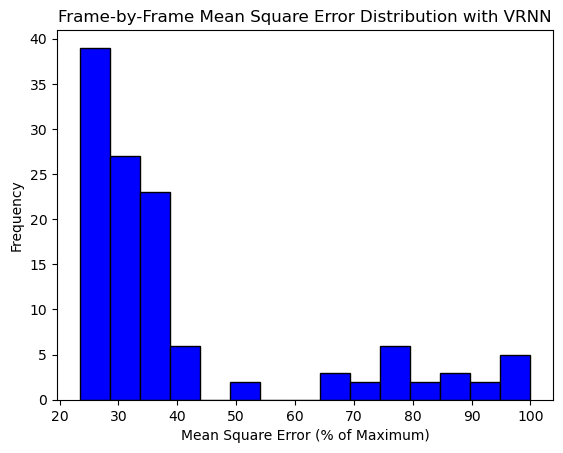

In [24]:
#Make Histogram for Frame-by-Frame MSE
example_video = mse_list_videos[10]
frame_max = np.max(example_video)
frames_norm = (example_video/frame_max)*100

# Create the histogram
plt.hist(frames_norm, bins=15, color='blue', edgecolor='black')

# Add labels and title
plt.xlabel('Mean Square Error (% of Maximum)')
plt.ylabel('Frequency')
plt.title('Frame-by-Frame Mean Square Error Distribution with VRNN')


In [25]:
for it in range (0,44):
    run_vmaf(driving_y4m_dir+f'/video_{it:02d}.y4m',pred_y4m_dir+f'/video_{it:02d}.y4m',vrnn_vmaf_output+f'/vmaf_{it:02d}.json')

sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf: not found
sh: 1: vmaf

In [24]:
#Read all VMAF outputs into a list variable
vmaf_outputs = []
for output_num in range(0,44):
    with open(vrnn_vmaf_output + f'/vmaf_{output_num:02d}.json','r') as file:
        vmaf_outputs.append(json.load(file))

In [25]:
#Get all per-video VMAF scores 
vmaf_scores = []
for score in vmaf_outputs:
    vmaf_scores.append(score['pooled_metrics']['vmaf']['mean'])
#10

In [26]:
#Get all per-video MSE scores
mse_scores = []
for video in mse_list_videos:
    mse_scores.append(np.mean(video))

In [30]:
#Take one video as an example of per-frame scores
vmaf_example_video = vmaf_outputs[10]['frames']
frame_vmaf_scores = []
for frame in vmaf_example_video:
    frame_vmaf_scores.append(frame['metrics']['vmaf'])
mse_example_video = mse_list_videos[10]

Text(0.5, 1.0, 'Distribution of Frame-by-Frame VMAF Scores for VRNN')

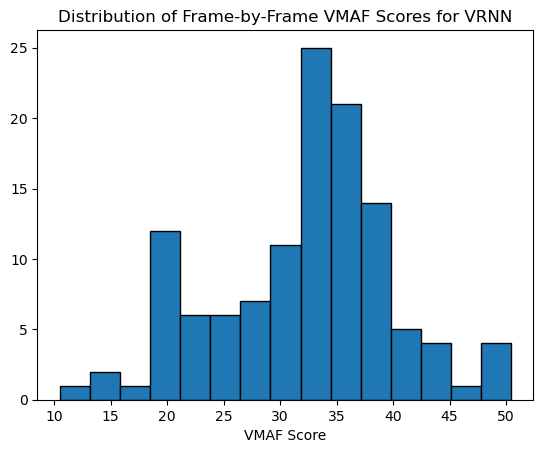

In [31]:
#Within-video VMAF-Frame Distribution
plt.hist(frame_vmaf_scores, bins=15, edgecolor = 'black')
plt.xlabel('VMAF Score')
plt.title('Distribution of Frame-by-Frame VMAF Scores for VRNN')

Text(0.5, 1.0, 'Distribution of Frame-by-Frame Mean Square Error')

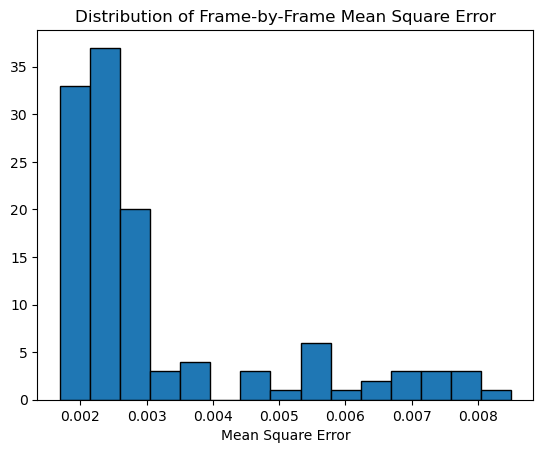

In [30]:
#Within-video MSE-Frame Distribution
plt.hist(mse_example_video, bins=15, edgecolor = 'black')
plt.xlabel('Mean Square Error')
plt.title('Distribution of Frame-by-Frame Mean Square Error for VRNN')

Text(0.5, 1.0, 'Scatterplot of Mean Square Error and VMAF Score by Video for VRNN')

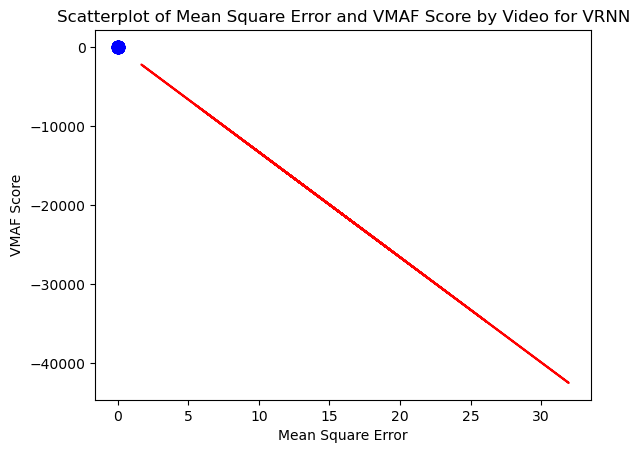

In [31]:
#Per-Video VMAF and MSE Scatterplot -- Without normalization
plt.scatter(mse_scores, vmaf_scores, color='blue', marker='o', s=75)

m, b = np.polyfit(mse_scores,vmaf_scores, 1)

plt.plot(vmaf_scores, m*np.array(vmaf_scores) + b, color='red', label='Regression line')

plt.xlabel('Mean Square Error')
plt.ylabel('VMAF Score')
plt.title('Scatterplot of Mean Square Error and VMAF Score by Video for VRNN')

Text(0.5, 1.0, 'Scatterplot of Normalized Mean Square Error and VMAF Score by Video')

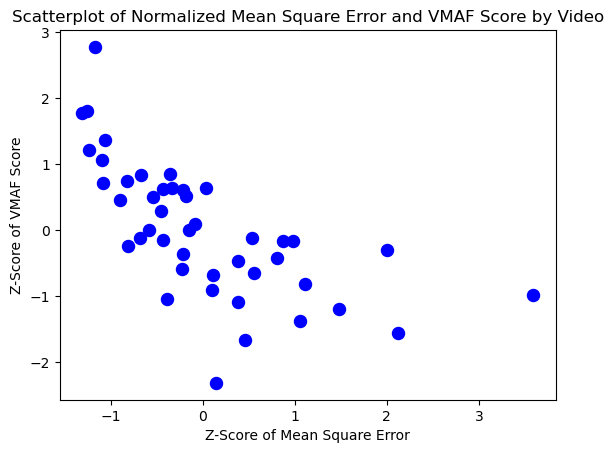

In [32]:
#Per-Video VMAF and MSE Scatterplot -- With normalization
mse_norm = (mse_scores - np.mean(mse_scores))/np.std(mse_scores)
vmaf_norm = (vmaf_scores - np.mean(vmaf_scores))/np.std(vmaf_scores)
plt.scatter(mse_norm, vmaf_norm, color='blue', marker='o', s=75)
plt.xlabel('Z-Score of Mean Square Error')
plt.ylabel('Z-Score of VMAF Score')
plt.title('Scatterplot of Normalized Mean Square Error and VMAF Score by Video')

In [34]:
np.corrcoef(mse_scores, vmaf_scores)

array([[ 1.        , -0.66425666],
       [-0.66425666,  1.        ]])